In [1]:
import sklearn
from scipy.stats import bootstrap as boot
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
sns.set_theme()

In [2]:
df = pd.read_csv('C:/Users/unstr/Documents/6 семестр работы/Отрынки/mortgage_project_2024/arctic1008_new.csv')
df = df.dropna(subset = 'P_avg_per_m_new')
tmp = df.groupby('city_id').agg({'month_dt':'min'})['month_dt']
min_set = {i for i in tmp.index if tmp.loc[i] <= '2023-01-01'}

tmp = df.groupby('city_id').agg({'month_dt':'max'})['month_dt']
max_set = {i for i in tmp.index if tmp.loc[i] >= '2024-04-01'}

df = df[df['city_id'].isin(min_set.intersection(max_set))&(df['month_dt']>='2022-05-01')]

tmp = df.groupby('city_id').apply(lambda x: len(x))
final_set = {i for i in tmp.index if tmp.loc[i] >= 24}
df = df[df['city_id'].isin(final_set)&(df['month_dt']>='2022-05-01')&(df['month_dt']<='2024-04-01')]
control_cities = list(set(list(df.query('dummy_space== 0')['city_id'])))
len(control_cities)


C:\Users\unstr\AppData\Local\Temp\ipykernel_25404\285440922.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tmp = df.groupby('city_id').apply(lambda x: len(x))


45

In [3]:
treatment_cities = list(set(list(df.query('dummy_space== 1')['city_id'])))
len(treatment_cities)

1

In [4]:
import random
random.seed(37)
group_of_items = control_cities  
num_to_select = 1                           
list_of_random_items = random.sample(group_of_items, num_to_select)
df['placebo_flg'] = df['city_id'].apply(lambda x: int(x in list_of_random_items))

In [27]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from datetime import datetime

def synth_ci_new(df
    , alpha:float
    , id_name = 'city_id' 
    , t_name = 'month_dt'
    , dummy_space_name = 'dummy_space' 
    , t_treatment = '2023-12-01'
    , y_name = 'P_avg_per_m_new'
    , trend = False
    , placebo = False
    , dummies = True
    ):
    
    df['city_id'] = df['city_id'].astype(str)
    treatment_cities = list(set(list(df.query(dummy_space_name+'== 1')[id_name])))
    placebo_cities = list(set(list(df.query('placebo_flg == 1')[id_name])))

    def sc(control_city_id_list:list):
        '''Функция, которая принимает на вход DataFrame с id городов 
        и выдаёт временной ряд среднего эффекта воздействия'''
        sub_df = df[df[id_name].apply(lambda x: x in control_city_id_list or x in placebo_cities or x in treatment_cities)]
        
        tmps =[]
        if not placebo:
            cities_list = treatment_cities
        else:
            cities_list = placebo_cities

        #Идём по городам воздействия
        # if len(cities_list) == 0:
        #     return pd.DataFrame({'y_true':[], 'y_predict': []
        #                     , t_name:[]})
        for city in cities_list:
            #Берём один город плацебо|воздействия и все контрольные
            tmp = sub_df[(sub_df[id_name] == city) | (sub_df[dummy_space_name] == 0) & (sub_df['placebo_flg'] == 0)]
            #Вытягиваем в столбик и потом конкатенируем
            tmp = tmp.pivot(index = t_name, columns = id_name, values = y_name).reset_index()
            #Добавляем фиктивную переменную города для сдвига
            tmp['tr_city_id'] = city
            tmp['tr_city'] = tmp[city]
            tmp.drop(columns = city, inplace = True)
            tmps += [tmp]        

        tmp = pd.concat(tmps)
        
        if trend:
            #Разница в датах считается в днях, потому что по-другому я не смог
            tmp['t'] = tmp[t_name].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))-datetime.strptime('2022-04-01', '%Y-%m-%d')
            tmp['t'] = tmp['t'].apply(lambda x: abs(x).days)

        if dummies:
            #Делаю фиктивные переменные городов воздействия/плацебо 
            enc = OneHotEncoder(sparse_output=False, drop='first')
            enc_transformed = enc.fit_transform(tmp[['tr_city_id']])
            enc_df = pd.DataFrame(columns=enc.get_feature_names_out(), data=enc_transformed)
            tmp = pd.concat([tmp.reset_index(drop=True), enc_df.reset_index(drop=True)], axis=1)

        tmp.drop(columns = 'tr_city_id', inplace=True)        
        tmp.fillna(method = 'ffill', inplace = True)
        #Обучаем регрессию на претренде
        train = tmp.loc[tmp[t_name] < t_treatment]
        scaler = StandardScaler()
        lr = Lasso(alpha=alpha)
        lr.fit(scaler.fit_transform(train.drop(columns = ['tr_city', t_name])), train['tr_city'])
            #Записываем в результат разницу между истинным значением и предиктом
        res = pd.DataFrame({'y_true':tmp['tr_city'], 'y_predict': lr.predict(scaler.transform(tmp.drop(columns = ['tr_city', t_name])))
                            , t_name:tmp[t_name]}).groupby(t_name, as_index=False).agg('mean')
        return res
    
    cities_list = list(set(list(df[(df[dummy_space_name] == 0) & (df['placebo_flg'] == 0)][id_name])))

    res1 = sc(cities_list)
    
    # Тут пишем бутстрап
    def boot_sc(df):
        tmp = sc(df)
        return tmp['y_true'] -tmp['y_predict'] 
    b = boot((cities_list,), boot_sc, n_resamples=1000, method = 'basic')

    res1['lower'] = b.confidence_interval.low
    res1['upper'] = b.confidence_interval.high

    return res1

C:\Users\unstr\AppData\Local\Temp\ipykernel_25404\3170209472.py:65: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  tmp.fillna(method = 'ffill', inplace = True)
C:\Users\unstr\AppData\Local\Temp\ipykernel_25404\3170209472.py:65: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  tmp.fillna(method = 'ffill', inplace = True)
C:\Users\unstr\AppData\Local\Temp\ipykernel_25404\3170209472.py:65: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  tmp.fillna(method = 'ffill', inplace = True)
C:\Users\unstr\AppData\Local\Temp\ipykernel_25404\3170209472.py:65: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  tmp.fillna(method = 'ffill', inplace = Tr

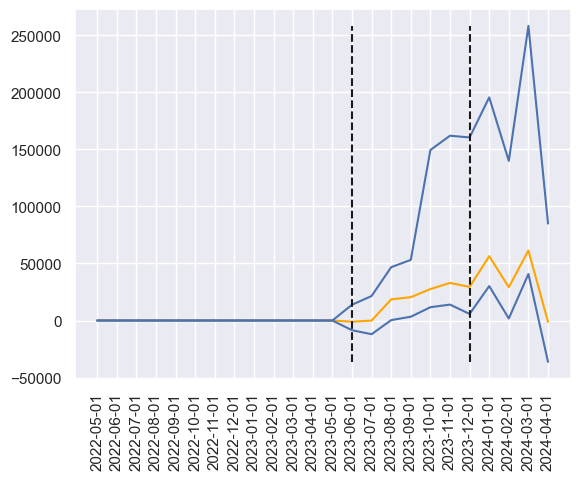

In [32]:
t_treatment= '2023-06-01'
data = synth_ci_new(df, 1e-3, t_treatment= t_treatment, trend=True, dummies=True)
data['diff'] = data['y_true'] - data['y_predict']
plt.plot(data['month_dt'], data['diff'], color = 'orange')
plt.xticks(rotation =90)
plt.plot(data['month_dt'], data['upper'], color = 'b')
plt.plot(data['month_dt'], data['lower'], color = 'b')
plt.vlines(x = ['2023-12-01', t_treatment], ymin = data['lower'].min(), ymax = data['upper'].max(), colors='k', linestyles='--')

C:\Users\unstr\AppData\Local\Temp\ipykernel_25404\3170209472.py:65: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  tmp.fillna(method = 'ffill', inplace = True)
C:\Users\unstr\AppData\Local\Temp\ipykernel_25404\3170209472.py:65: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  tmp.fillna(method = 'ffill', inplace = True)
C:\Users\unstr\AppData\Local\Temp\ipykernel_25404\3170209472.py:65: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  tmp.fillna(method = 'ffill', inplace = True)
C:\Users\unstr\AppData\Local\Temp\ipykernel_25404\3170209472.py:65: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  tmp.fillna(method = 'ffill', inplace = Tr

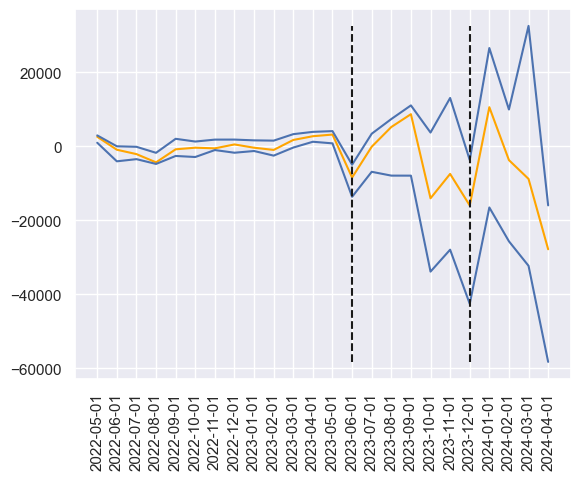

In [35]:
t_treatment= '2023-06-01'
data = synth_ci_new(df, 1e3, t_treatment= t_treatment, trend=True, dummies=True)
data['diff'] = data['y_true'] - data['y_predict']
plt.plot(data['month_dt'], data['diff'], color = 'orange')
plt.xticks(rotation =90)
plt.plot(data['month_dt'], data['upper'], color = 'b')
plt.plot(data['month_dt'], data['lower'], color = 'b')
plt.vlines(x = ['2023-12-01', t_treatment], ymin = data['lower'].min(), ymax = data['upper'].max(), colors='k', linestyles='--')

C:\Users\unstr\AppData\Local\Temp\ipykernel_25404\3170209472.py:65: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  tmp.fillna(method = 'ffill', inplace = True)
C:\Users\unstr\AppData\Local\Temp\ipykernel_25404\3170209472.py:65: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  tmp.fillna(method = 'ffill', inplace = True)
C:\Users\unstr\AppData\Local\Temp\ipykernel_25404\3170209472.py:65: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  tmp.fillna(method = 'ffill', inplace = True)
C:\Users\unstr\AppData\Local\Temp\ipykernel_25404\3170209472.py:65: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  tmp.fillna(method = 'ffill', inplace = Tr

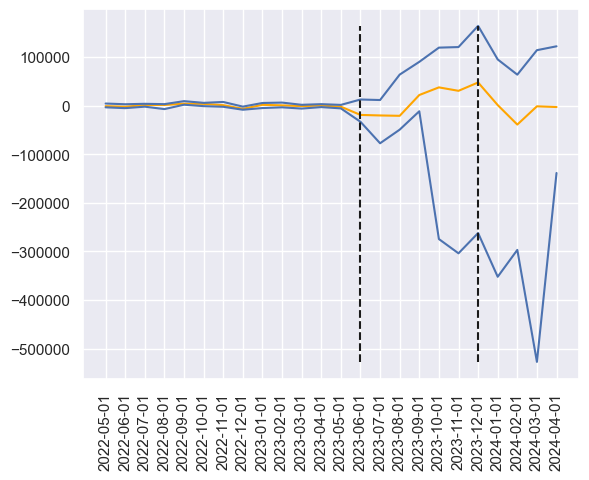

In [36]:
#Плацебо тест на претренде
t_treatment= '2023-06-01'
data = synth_ci_new(df, 1e3, t_treatment= t_treatment, trend=True, placebo = True, dummies = True)
data['diff'] = data['y_true'] - data['y_predict']
plt.plot(data['month_dt'], data['diff'], color = 'orange')
plt.xticks(rotation =90)
plt.plot(data['month_dt'], data['upper'], color = 'b')
plt.plot(data['month_dt'], data['lower'], color = 'b')
plt.vlines(x = ['2023-12-01', t_treatment], ymin = data['lower'].min(), ymax = data['upper'].max(), colors='k', linestyles='--')


C:\Users\unstr\AppData\Local\Temp\ipykernel_25404\3170209472.py:65: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  tmp.fillna(method = 'ffill', inplace = True)
C:\Users\unstr\AppData\Local\Temp\ipykernel_25404\3170209472.py:65: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  tmp.fillna(method = 'ffill', inplace = True)
C:\Users\unstr\AppData\Local\Temp\ipykernel_25404\3170209472.py:65: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  tmp.fillna(method = 'ffill', inplace = True)
C:\Users\unstr\AppData\Local\Temp\ipykernel_25404\3170209472.py:65: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  tmp.fillna(method = 'ffill', inplace = Tr

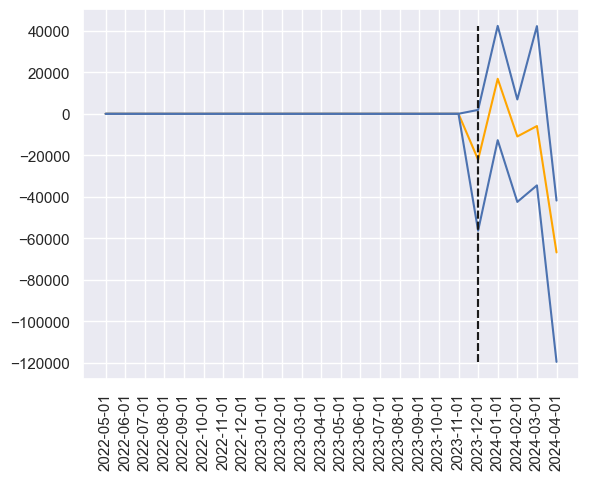

In [34]:
#Эффект воздействия, если обучаться на всём претренде
t_treatment= '2023-12-01'
data = synth_ci_new(df, 1e-3, t_treatment= t_treatment, trend=True, dummies=True)
data['diff'] = data['y_true'] - data['y_predict']
plt.plot(data['month_dt'], data['diff'], color = 'orange')
plt.xticks(rotation =90)
plt.plot(data['month_dt'], data['upper'], color = 'b')
plt.plot(data['month_dt'], data['lower'], color = 'b')
plt.vlines(x = ['2023-12-01', t_treatment], ymin = data['lower'].min(), ymax = data['upper'].max(), colors='k', linestyles='--')